<a href="https://colab.research.google.com/github/Vamsikrishna1804/Vamsikrishnabharghava_INFO5731_Spring2021/blob/main/In_class_exercise_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The seventh in-class-exercise (20 points in total, 3/16/2021)**

Question description: In the last in-class-exercise (exercise-06), you collected the titles of 100 articles about data science, natural language processing, and machine learning. The 100 article titles will be used as the text corpus of this exercise. Perform the following tasks:

## (1) (8 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [ ]:
# Write your code here
import re
import os
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7MB 7.8MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=409d59f735f487f9560380fd8fc92d58865d086b4aac4d2932baaa8af275240b
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyLDAvis


In [ ]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# NLTK Stop words
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
df = pd.read_csv('titles.csv')
df.head(100)


,Unnamed: 0,Journal Data
0,0,A general framework for causal classification
1,1,Introduction to the special issue on social mi...
2,2,Linking bank clients using graph neural networ...
3,3,A survey on training and evaluation of word em...
4,4,Using network features for credit scoring in m...
...,...,...
95,95,Correction to: A clinical risk matrix for obst...
96,96,Introduction to the special issue on social da...
97,97,Accurate classification of socially generated ...
98,98,Multi-domain and multi-view networks model for...


In [ ]:
# Convert to list
data = df['Journal Data'].tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['A general framework for causal classification']


In [ ]:
def sentence_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sentence_to_words(data))

print(data_words[:1])

[['general', 'framework', 'for', 'causal', 'classification']]


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['general', 'framework', 'for', 'causal', 'classification']


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
Clean_data = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(Clean_data[:1])

[['classification']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(Clean_data)

# Create Corpus
texts = Clean_data

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1)]]


In [ ]:
id2word[0]

'classification'

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('classification', 1)]]

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.059*"detection" + 0.055*"data" + 0.046*"optimization" + 0.046*"automatic" '
  '+ 0.036*"datum" + 0.031*"use" + 0.030*"ensemble" + 0.030*"dynamic" + '
  '0.027*"outlier" + 0.023*"problem"'),
 (1,
  '0.082*"challenge" + 0.051*"datum" + 0.038*"medicine" + 0.038*"quality" + '
  '0.034*"detection" + 0.034*"outlier" + 0.027*"big" + 0.027*"model" + '
  '0.027*"source" + 0.027*"dimension"'),
 (2,
  '0.055*"law" + 0.033*"multi" + 0.017*"eigenanalysis" + 0.017*"consistently" '
  '+ 0.017*"model" + 0.017*"basis" + 0.017*"orient" + 0.017*"department" + '
  '0.017*"admission" + 0.017*"network"'),
 (3,
  '0.082*"classification" + 0.049*"prescription" + 0.049*"forecast" + '
  '0.038*"study" + 0.027*"mining" + 0.023*"episode" + 0.023*"tract" + '
  '0.023*"planning" + 0.023*"respiratory" + 0.023*"causally"'),
 (4,
  '0.091*"text" + 0.038*"latent" + 0.038*"long" + 0.038*"short" + '
  '0.038*"model" + 0.027*"autoregression" + 0.027*"range" + 0.027*"cross" + '
  '0.027*"forecasting" + 0.023*"neu

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=Clean_data, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.8162956953607

Coherence Score:  0.3900510933478749


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11     0.167387 -0.238616       1        1  8.042376
14    -0.217333 -0.156621       2        1  7.002350
9     -0.062562  0.078029       3        1  6.760189
12     0.000419  0.078234       4        1  6.515335
15     0.056284  0.134535       5        1  6.484310
0     -0.102738  0.051174       6        1  6.311748
17     0.071468  0.026326       7        1  5.864659
6     -0.029107  0.036019       8        1  5.385494
13     0.078833 -0.002813       9        1  4.923487
8      0.055567  0.090086      10        1  4.916915
1     -0.123294 -0.010930      11        1  4.806075
18     0.020087 -0.059970      12        1  4.776728
16     0.069517  0.010307      13        1  4.526518
5     -0.077799  0.001815      14        1  4.484718
10     0.036257 -0.015026      15        1  4.073253
3      0.032383  0.001588      16        1  3.741107
19    -0.034379 -0.028047      17        1  3.677565
4      0.053532  0.030106      18        1  3.215510
7     -0.005238 -0.018755      19        1  2.489146
2      0.010715 -0.007439      20        1  2.002514, topic_info=               Term      Freq      Total Category  logprob  loglift
2             datum  27.00000  27.000000  Default  30.0000  30.0000
66             base  14.00000  14.000000  Default  29.0000  29.0000
8           science  10.00000  10.000000  Default  28.0000  28.0000
38            model  14.00000  14.000000  Default  27.0000  27.0000
136          stream   7.00000   7.000000  Default  26.0000  26.0000
..              ...       ...        ...      ...      ...      ...
0    classification   0.02704   8.311887  Topic20  -6.7217  -1.8174
1               big   0.02704   6.182451  Topic20  -6.7217  -1.5214
3         ecosystem   0.02704   1.608087  Topic20  -6.7217  -0.1747
4             issue   0.02704   5.427883  Topic20  -6.7217  -1.3912
5            mining   0.02704   6.283535  Topic20  -6.7217  -1.5376

[749 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
434       9  0.582622     abandon
452      12  0.581343    academic
475       1  0.660672  accidental
99       13  0.625218    accuracy
476       1  0.851981          ad
...     ...       ...         ...
75        7  0.589869         web
25        7  0.452352        word
25       10  0.452352        word
33        2  0.621855    workflow
127       3  0.829104       world

[516 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 15, 10, 13, 16, 1, 18, 7, 14, 9, 2, 19, 17, 6, 11, 4, 20, 5, 8, 3])

In [ ]:
import os     
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       
install_java()
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
--2021-03-21 17:21:20--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip.1’

mallet-2.0.8.zip.1  100%[===================>]  15.43M  8.59MB/s    in 1.8s    

2021-03-21 17:21:22 (8.59 MB/s) - ‘mallet-2.0.8.zip.1’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
replace mallet-2.0.8/bin/classifier2info? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
mallet_path = '/content/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=Clean_data, start=2, limit=40, step=6)

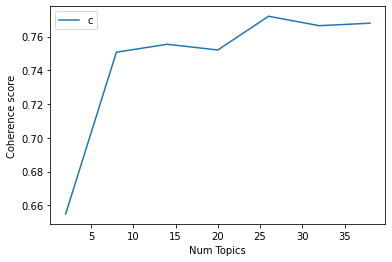

In [ ]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6549
Num Topics = 8  has Coherence Value of 0.7507
Num Topics = 14  has Coherence Value of 0.7554
Num Topics = 20  has Coherence Value of 0.7521
Num Topics = 26  has Coherence Value of 0.7721
Num Topics = 32  has Coherence Value of 0.7664
Num Topics = 38  has Coherence Value of 0.7679


In [ ]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.170*"learning" + 0.106*"challenge" + 0.064*"ensemble" + 0.043*"diagram" + '
  '0.043*"scalable" + 0.043*"sleep" + 0.043*"short" + 0.043*"member" + '
  '0.043*"perspective" + 0.043*"identify"'),
 (1,
  '0.179*"tree" + 0.071*"text" + 0.054*"interpretable" + 0.054*"unsupervise" + '
  '0.054*"variable" + 0.054*"entity" + 0.036*"purchase" + 0.036*"tract" + '
  '0.036*"similarity" + 0.036*"causal"'),
 (2,
  '0.120*"issue" + 0.100*"regression" + 0.060*"infection" + 0.040*"mechanism" '
  '+ 0.040*"episode" + 0.040*"estimation" + 0.040*"analysis" + '
  '0.040*"likelihood" + 0.040*"matrix" + 0.040*"maximum"'),
 (3,
  '0.123*"learn" + 0.046*"document" + 0.046*"bias" + 0.046*"meet" + '
  '0.046*"inference" + 0.046*"influence" + 0.031*"accuracy" + 0.031*"web" + '
  '0.031*"optimize" + 0.031*"research"'),
 (4,
  '0.127*"algorithm" + 0.127*"pattern" + 0.055*"data" + 0.036*"base" + '
  '0.036*"mobile" + 0.036*"infrastructure" + 0.036*"miss" + 0.036*"sensitive" '
  '+ 0.018*"mahalanobis" + 0.

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.0643,"classification, long, forecast, scoring, predi...",A general framework for causal classification
1,1,19.0,0.0993,"datum, online, statistic, prediction, deep, me...",Introduction to the special issue on social mi...
2,2,12.0,0.0861,"network, graph, multi, embedding, neural, larg...",Linking bank clients using graph neural networ...
3,3,12.0,0.0859,"network, graph, multi, embedding, neural, larg...",A survey on training and evaluation of word em...
4,4,12.0,0.0818,"network, graph, multi, embedding, neural, larg...",Using network features for credit scoring in m...
5,5,4.0,0.0669,"algorithm, pattern, data, base, mobile, infras...",A workflow language for research e-infrastruct...
6,6,11.0,0.0660,"detection, big, embed, medium, content, heartb...",Detection of causally anomalous time-series
7,7,5.0,0.0792,"outlier, optimization, stream, automatic, reve...",An influence model for influence maximization–...
8,8,16.0,0.0847,"feature, correct, solution, context, detect, f...",Exploiting feature fusion and long-term contex...
9,9,13.0,0.0665,"science, training, application, workflow, page...",Mitigating sentimental bias via a polar attent...


In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.0880,"learning, challenge, ensemble, diagram, scalab...",An improved machine learning application for t...
1,1.0,0.1157,"tree, text, interpretable, unsupervise, variab...",Causal tree with instrumental variable: an ext...
2,2.0,0.1255,"issue, regression, infection, mechanism, episo...",Least squares and maximum likelihood estimatio...
3,3.0,0.1293,"learn, document, bias, meet, inference, influe...",When algorithm selection meets Bi-linear Learn...
4,4.0,0.0848,"algorithm, pattern, data, base, mobile, infras...",Classifying sensitive content in online advert...


In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,7.0,"classification, long, forecast, scoring, predi...",10.0,0.0625
1.0,19.0,"datum, online, statistic, prediction, deep, me...",9.0,0.0562
2.0,12.0,"network, graph, multi, embedding, neural, larg...",10.0,0.0625
3.0,12.0,"network, graph, multi, embedding, neural, larg...",13.0,0.0812
4.0,12.0,"network, graph, multi, embedding, neural, larg...",11.0,0.0688
...,...,...,...,...
155.0,19.0,"datum, online, statistic, prediction, deep, me...",NaN,NaN
156.0,19.0,"datum, online, statistic, prediction, deep, me...",NaN,NaN
157.0,6.0,"social, mining, approach, service, scale, clin...",NaN,NaN
158.0,13.0,"science, training, application, workflow, page...",NaN,NaN


## (2) (8 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [ ]:
# Write your code here

#import modules
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [ ]:
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r") as fin:
        for line in fin.readlines():
            text = line.strip()
            documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles

In [ ]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [ ]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [ ]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [ ]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

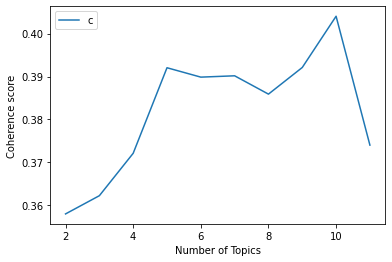

In [ ]:
start,stop,step=2,12,1
plot_graph(Clean_data,start,stop,step)

In [ ]:
# LSA Model
number_of_topics=6
words=10
model=create_gensim_lsa_model(Clean_data,number_of_topics,words)

[(0, '0.779*"datum" + 0.210*"use" + 0.208*"science" + 0.164*"big" + 0.157*"social" + 0.154*"mining" + 0.124*"analytic" + 0.111*"model" + 0.109*"network" + 0.105*"special"'), (1, '-0.456*"use" + -0.291*"base" + -0.272*"feature" + 0.247*"datum" + -0.223*"detection" + -0.216*"outlier" + -0.198*"network" + -0.194*"model" + 0.150*"science" + 0.128*"big"'), (2, '-0.478*"base" + -0.338*"feature" + 0.295*"use" + 0.277*"model" + 0.222*"outlier" + 0.186*"detection" + -0.156*"algorithm" + -0.140*"selection" + 0.138*"optimization" + -0.124*"approach"'), (3, '0.737*"model" + -0.250*"outlier" + -0.236*"detection" + -0.153*"use" + 0.127*"classification" + 0.124*"multi" + -0.123*"tree" + 0.120*"analysis" + -0.102*"automatic" + -0.097*"ensemble"'), (4, '-0.404*"network" + 0.281*"base" + 0.278*"detection" + 0.268*"outlier" + -0.257*"use" + -0.175*"feature" + -0.153*"neural" + 0.138*"tree" + 0.136*"model" + 0.131*"automatic"'), (5, '0.384*"feature" + 0.316*"classification" + -0.268*"approach" + 0.202*"ex

In [ ]:
dictionary,doc_term_matrix= prepare_corpus(Clean_data)
model_list_lsa,coherence_values_lsa = compute_coherence_values(dictionary,doc_term_matrix,Clean_data,40,2,6)


In [ ]:
x = range(start, stop, step)
for m, cv in zip(x, coherence_values_lsa):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4254
Num Topics = 3  has Coherence Value of 0.4002
Num Topics = 4  has Coherence Value of 0.3941
Num Topics = 5  has Coherence Value of 0.3736
Num Topics = 6  has Coherence Value of 0.3877
Num Topics = 7  has Coherence Value of 0.4098
Num Topics = 8  has Coherence Value of 0.4305


## (3) (4 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

In [ ]:
# Write your answer here (no code needed for this question)

'''
LDA(Latent Dirichlet Allocation):
LDA is one of the most popular topic modelling method. It classifies text into relevant topics.By finding the probability of finding a word in text and comparing it
to probability of finding in relevant topic and then it allocates the topic . Using Gensim's LDA we can see that the optimal number of topics are 18 and
coherence score obtained by applying LDA method is 0.77.


LSA (Latent Semantic Analysis)
Another Key model in topic modelling . It determines the topics by converting the text into single value equation by using SVD and then finds the cosine similarity to 
all the topics. The topics having the highest cosine similarity is allocated as the key topic. From the above observations , we can see that Coherence Value:0.42 and
number of topics is 2.

By Comparing both the scores we can see that we have higher coherence score for LDA than LSA. Since higher coherence score implies better alignment towards a topic,
LDA fits the text best for topic modelling.


'''

